In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

In [2]:
device = torch.device("cpu")
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def PoissonGen(inp, rescale_fac=2.0):
    rand_inp = torch.rand_like(inp)
    return torch.mul(torch.le(rand_inp * rescale_fac, torch.abs(inp)).float(), torch.sign(inp))

In [4]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        
        self.fc_1 = nn.Linear(28*28,6,bias=False)
        self.fc_2 = nn.Linear(6,4,bias=False)
        self.fc_out = nn.Linear(4,10,bias=False)
        self.lif1 = LIF()
        self.lif2 = LIF()
        self.time_step = 11
        self.s_regs_inp = None
        
#         for m in self.modules():
#             if isinstance(m,nn.Linear):
#                 n = m.weight.size(1)
#                 m.weight.data.normal_(0,5.0/float(n))
        
    def forward(self, inp):
        inp = inp.view(inp.shape[0],-1)
        size = inp.shape
        self.s_regs_inp = torch.zeros(self.time_step,*size)
        u_out = 0
        
        for t in range(self.time_step):
            
            spike_inp = PoissonGen(inp)
            self.s_regs_inp[t].data += spike_inp 
            
            x = self.fc_1(spike_inp)
            x = self.lif1(x, t)
            x = self.fc_2(x)
            x = self.lif2(x, t)
            x = self.fc_out(x)
            u_out = u_out + x
        return u_out

In [5]:
class LIF(nn.Module):
    def __init__(self):
        super(LIF, self).__init__()
        
        self.u_regs = None
        self.du_regs = None
        self.s_regs = None
        self.leak = 0.8
        self.time_step = 20
        self.thresh = 0.5
        
    def forward(self,inp,t):
        if t == 0:
            size = inp.shape
            self.u_regs = torch.zeros(self.time_step,*size)
            self.du_regs = torch.zeros(self.time_step,*size)
            self.u_regs[0] = inp
            self.s_regs = torch.zeros(self.time_step,*size)

            vol = inp - self.thresh

            spike = spike_function(vol, k=1)

            self.s_regs[0] = spike
        else:
            self.u_regs[t] = self.leak * self.u_regs[t-1] * (1 - self.s_regs[t-1]) + inp

            vol = self.u_regs[t] - self.thresh

            spike = spike_function(vol, k=1)

            self.s_regs[t] = spike

        return spike

        

def spike_function(x, k):

    x[x>0] = 1
    x[x<=0] = 0

    return x

def de_func(U,th):
    alpha = 0.3
    U = alpha*(1.0 - abs((U-th)/th))
    U[U<0]=0
    return U

In [6]:
### Back propagation
def bp(toy,leak,time_step,du_out,s_regs_inp,l_r,th):
    
    ## Second fc    
    du_fc2 = torch.matmul(du_out,toy.fc_out.weight)*de_func(toy.lif2.u_regs[-1],th)    
    toy.lif2.du_regs[-1].data += du_fc2

    ## First fc
    du_fc1 = torch.matmul(du_fc2,toy.fc_2.weight)*de_func(toy.lif1.u_regs[-1],th)
    toy.lif1.du_regs[-1].data += du_fc1

    ## Update weight
    w_inp_1 = torch.matmul(torch.transpose(du_fc1,0,1),s_regs_inp[-1])
    toy.fc_1.weight.data += w_inp_1

    w_1_2 = torch.matmul(torch.transpose(du_fc2,0,1),toy.lif1.s_regs[-1])
    toy.fc_2.weight.data += w_1_2

    w_2_out = torch.matmul(torch.transpose(du_out,0,1),toy.lif2.s_regs[-1])
    toy.fc_out.weight.data += w_2_out

    for t in range(time_step-2,-1,-1):
        ds_fc2 = torch.matmul(du_out,toy.fc_out.weight)+toy.lif2.du_regs[t+1]*(-leak*toy.lif2.u_regs[t])
        du_fc2 = (ds_fc2)*de_func(toy.lif2.u_regs[t],th) + toy.lif2.du_regs[t+1]*leak*(1-toy.lif2.s_regs[t])
        toy.lif2.du_regs[t].data += du_fc2
        
        ## First fc
        ds_fc1 = torch.matmul(du_fc2,toy.fc_2.weight)+toy.lif1.du_regs[t+1]*(-leak*toy.lif1.u_regs[t])
        du_fc1 = (ds_fc1)*de_func(toy.lif1.u_regs[t],th) + toy.lif1.du_regs[t+1]*leak*(1-toy.lif1.s_regs[t])
        toy.lif1.du_regs[t].data += du_fc1

        ## Update weight

        w_inp_1 = torch.matmul(torch.transpose(du_fc1,0,1),s_regs_inp[t])
        toy.fc_1.weight.data -= l_r*w_inp_1

        w_1_2 = torch.matmul(torch.transpose(du_fc2,0,1),toy.lif1.s_regs[t])
        toy.fc_2.weight.data -= l_r*w_1_2

        w_2_out = torch.matmul(torch.transpose(du_out,0,1),toy.lif2.s_regs[t])
        toy.fc_out.weight.data -= l_r*w_2_out


In [7]:
import torch
import torchvision

batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [8]:
test_losses = []
train_losses = []
train_counter = []
test_counter = [i*len(train_loader.dataset) for i in range(10 + 1)]
log_interval = 10

def test():
  
    test_loss = 0
    correct = 0
    for data, target in test_loader:
      output = toy(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [9]:
toy = model()
leak = 0.99
time_step = 10
lr = 0.001
loss = nn.CrossEntropyLoss()

test()
for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        out = toy(data)
#         if torch.isnan(out).any():
#             print("Nan Debug found, out,i=",batch_idx)
            
        err = loss(out,target)
        exp = torch.exp(out)
        exp_sum = torch.sum(torch.exp(out),1, keepdim=True)
        target = F.one_hot(target, num_classes=10)
        L = -1*torch.sum((target*torch.log((exp/exp_sum))),1, keepdim=True)
        
        
        du_out = exp/exp_sum
        du_out = du_out - target
        
        #print("out is:",out)
#         if torch.isnan(du_out).any():
#             if torch.isnan(torch.exp(out)).any():
#                 print("exp has nan")
#             if torch.isnan(target).any():
#                 print("target has nan")
#             print("Nan Debug found, du_out,bp,i=",batch_idx)
#             print("du_out: ",du_out)
#             print("exp sum:",torch.sum(torch.exp(out),1, keepdim=True))
#             print("exp:",torch.exp(out))
#             print("out",out)
            
        
        bp(toy,leak,time_step,du_out,toy.s_regs_inp,lr,toy.lif1.thresh)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), err.item()))
            train_losses.append(err.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        #print("error is: ", err) 
#         if torch.isnan(err):
#             print("Nan is found, epoch",epoch,"i is",batch_idx)
#             break
    print("err:", err)
    test()
    if torch.isnan(err):
        break
#l = -1*u_out[0][1]+torch.log(torch.exp(u_out[0][0])+torch.exp(u_out[0][1]))

# print("err:",err)
# print("u_out:",u_out)
#torch.exp(u_out[0][0])/(torch.exp(u_out[0][0])+torch.exp(u_out[0][1])+torch.exp(u_out[0][2]))-0
#print(err)
# toy.lif2.u_regs.register_hook(print)
# err.backward()

## Use same Output derivative throught bp


#print(du_out)
#print(toy.fc_out.weight)

#print(toy.fc_out.weight)

C:\Users\Ruokai\anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: -0.0283, Accuracy: 962/10000 (10%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.492788
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.311037
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.228962
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.054328
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.098115
Train Epoch: 0 [3200/60000 (5%)]	Loss: 1.951510
Train Epoch: 0 [3840/60000 (6%)]	Loss: 1.774833
Train Epoch: 0 [4480/60000 (7%)]	Loss: 1.814049
Train Epoch: 0 [5120/60000 (9%)]	Loss: 1.730332
Train Epoch: 0 [5760/60000 (10%)]	Loss: 1.831321
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.569038
Train Epoch: 0 [7040/60000 (12%)]	Loss: 1.485887
Train Epoch: 0 [7680/60000 (13%)]	Loss: 1.373265
Train Epoch: 0 [8320/60000 (14%)]	Loss: 1.439399
Train Epoch: 0 [8960/60000 (15%)]	Loss: 1.437452
Train Epoch: 0 [9600/60000 (16%)]	Loss: 1.561408
Train Epoch: 0 [10240/60000 (17%)]	Loss: 1.534433
Train Epoch: 0 [10880/60000 (18%)]	Loss: 1.252344
Train Epoch: 0 [11520/60000 (19%)]	Loss: 1.357207
Train Epoch: 0 [12160

Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.891258
Train Epoch: 1 [44160/60000 (74%)]	Loss: 1.149889
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.964901
Train Epoch: 1 [45440/60000 (76%)]	Loss: 0.706216
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.687149
Train Epoch: 1 [46720/60000 (78%)]	Loss: 0.587199
Train Epoch: 1 [47360/60000 (79%)]	Loss: 1.148082
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.845749
Train Epoch: 1 [48640/60000 (81%)]	Loss: 1.042078
Train Epoch: 1 [49280/60000 (82%)]	Loss: 0.702906
Train Epoch: 1 [49920/60000 (83%)]	Loss: 1.048540
Train Epoch: 1 [50560/60000 (84%)]	Loss: 0.638946
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.739415
Train Epoch: 1 [51840/60000 (86%)]	Loss: 0.919763
Train Epoch: 1 [52480/60000 (87%)]	Loss: 1.163134
Train Epoch: 1 [53120/60000 (88%)]	Loss: 0.794037
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.733852
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.825500
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.700078
Train Epoch: 1 [55680/60000 (93%)]	Loss: 0.544064


Train Epoch: 3 [26240/60000 (44%)]	Loss: 0.925632
Train Epoch: 3 [26880/60000 (45%)]	Loss: 0.725154
Train Epoch: 3 [27520/60000 (46%)]	Loss: 0.685832
Train Epoch: 3 [28160/60000 (47%)]	Loss: 0.620466
Train Epoch: 3 [28800/60000 (48%)]	Loss: 0.533664
Train Epoch: 3 [29440/60000 (49%)]	Loss: 0.478068
Train Epoch: 3 [30080/60000 (50%)]	Loss: 0.729895
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.519451
Train Epoch: 3 [31360/60000 (52%)]	Loss: 0.466126
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.482456
Train Epoch: 3 [32640/60000 (54%)]	Loss: 1.088239
Train Epoch: 3 [33280/60000 (55%)]	Loss: 0.830299
Train Epoch: 3 [33920/60000 (57%)]	Loss: 0.778499
Train Epoch: 3 [34560/60000 (58%)]	Loss: 1.032915
Train Epoch: 3 [35200/60000 (59%)]	Loss: 0.751515
Train Epoch: 3 [35840/60000 (60%)]	Loss: 0.610946
Train Epoch: 3 [36480/60000 (61%)]	Loss: 0.594293
Train Epoch: 3 [37120/60000 (62%)]	Loss: 0.693250
Train Epoch: 3 [37760/60000 (63%)]	Loss: 0.486782
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.717883


Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.589673
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.839469
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.623544
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.503080
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.426878
Train Epoch: 5 [12160/60000 (20%)]	Loss: 0.730309
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.659384
Train Epoch: 5 [13440/60000 (22%)]	Loss: 0.861463
Train Epoch: 5 [14080/60000 (23%)]	Loss: 0.600604
Train Epoch: 5 [14720/60000 (25%)]	Loss: 0.413244
Train Epoch: 5 [15360/60000 (26%)]	Loss: 0.554226
Train Epoch: 5 [16000/60000 (27%)]	Loss: 0.754626
Train Epoch: 5 [16640/60000 (28%)]	Loss: 0.646560
Train Epoch: 5 [17280/60000 (29%)]	Loss: 0.740247
Train Epoch: 5 [17920/60000 (30%)]	Loss: 0.584524
Train Epoch: 5 [18560/60000 (31%)]	Loss: 0.711029
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.700689
Train Epoch: 5 [19840/60000 (33%)]	Loss: 0.643275
Train Epoch: 5 [20480/60000 (34%)]	Loss: 0.923715
Train Epoch: 5 [21120/60000 (35%)]	Loss: 0.855866
Tr

Train Epoch: 6 [53120/60000 (88%)]	Loss: 0.431515
Train Epoch: 6 [53760/60000 (90%)]	Loss: 0.639261
Train Epoch: 6 [54400/60000 (91%)]	Loss: 0.798065
Train Epoch: 6 [55040/60000 (92%)]	Loss: 0.594399
Train Epoch: 6 [55680/60000 (93%)]	Loss: 0.577092
Train Epoch: 6 [56320/60000 (94%)]	Loss: 0.790812
Train Epoch: 6 [56960/60000 (95%)]	Loss: 0.965719
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.437971
Train Epoch: 6 [58240/60000 (97%)]	Loss: 0.453263
Train Epoch: 6 [58880/60000 (98%)]	Loss: 0.673875
Train Epoch: 6 [59520/60000 (99%)]	Loss: 0.490404
err: tensor(0.4894, grad_fn=<NllLossBackward>)

Test set: Avg. loss: -6.4254, Accuracy: 8141/10000 (81%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.627609
Train Epoch: 7 [640/60000 (1%)]	Loss: 0.528418
Train Epoch: 7 [1280/60000 (2%)]	Loss: 1.110731
Train Epoch: 7 [1920/60000 (3%)]	Loss: 0.642094
Train Epoch: 7 [2560/60000 (4%)]	Loss: 0.714544
Train Epoch: 7 [3200/60000 (5%)]	Loss: 0.658243
Train Epoch: 7 [3840/60000 (6%)]	Loss: 0.677901
Train Epoch:

Train Epoch: 8 [35840/60000 (60%)]	Loss: 0.866317
Train Epoch: 8 [36480/60000 (61%)]	Loss: 0.580645
Train Epoch: 8 [37120/60000 (62%)]	Loss: 0.741342
Train Epoch: 8 [37760/60000 (63%)]	Loss: 0.884768
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.814571
Train Epoch: 8 [39040/60000 (65%)]	Loss: 0.544525
Train Epoch: 8 [39680/60000 (66%)]	Loss: 0.638941
Train Epoch: 8 [40320/60000 (67%)]	Loss: 0.681608
Train Epoch: 8 [40960/60000 (68%)]	Loss: 0.955467
Train Epoch: 8 [41600/60000 (69%)]	Loss: 0.552356
Train Epoch: 8 [42240/60000 (70%)]	Loss: 0.574248
Train Epoch: 8 [42880/60000 (71%)]	Loss: 0.512479
Train Epoch: 8 [43520/60000 (72%)]	Loss: 0.913130
Train Epoch: 8 [44160/60000 (74%)]	Loss: 0.756427
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.611737
Train Epoch: 8 [45440/60000 (76%)]	Loss: 0.787470
Train Epoch: 8 [46080/60000 (77%)]	Loss: 0.613218
Train Epoch: 8 [46720/60000 (78%)]	Loss: 0.592552
Train Epoch: 8 [47360/60000 (79%)]	Loss: 0.900148
Train Epoch: 8 [48000/60000 (80%)]	Loss: 0.599045


Text(0, 0.5, 'negative log likelihood loss')

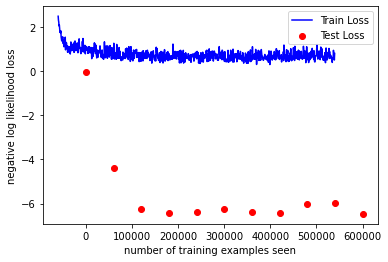

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')